# Do surroundings influence the nature of crime in a city ?  

***

### Problem  
Analyse & understand the relationship of how the surrounding venues impact the nature of the crime in a city  

### Targeted Towards   
Toronto Police -to equip them with quantitative information so crime can be better understood and averted   
New residents & Commercial property owners - to safeguard themselves better   

### Approach  
- Data from Toronto Police on Major crimes combined with venue data from foursquare   
- This combined data with details of the crime and the venues surrounding the crime scene is put through unsupervised clustering algorithm  
- Results are analysed to build an understanding of the relationship between venues and nature of crime  



### Getting the Dependencies 
With the approach and problem set up , lets get the dependencies   
Before we get the data and start exploring it, let's download all the dependencies that we will need 
Also the variables which we will use for accessing the foursquare API

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import numpy as np
import json
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt


from sklearn.cluster import KMeans
from sklearn import metrics

import folium # mapping library
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

CLIENT_ID = 'OWU5LYGCIFULB5FRPEBMPR5SFDBNMHWS4EBY5HSY0DY3TMX4' # your Foursquare ID
CLIENT_SECRET = 'MFCOPWOFDDXYN4FKURRCLAIZAPVPA3RPB3R2U3BVVY0TNZJH' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 300 # define radius

### Getting the data 

Toronto police publishes the major crime data which is our key source of data for this exploration  
http://data.torontopolice.on.ca/pages/major-crime-indicators  


In [2]:
MCI_raw = pd.read_csv('https://opendata.arcgis.com/datasets/98f7dde610b54b9081dfca80be453ac9_0.csv?outSR=%7B%22wkid%22%3A102100%2C%22latestWkid%22%3A3857%7D')

In [3]:
print(MCI_raw.columns)
print(MCI_raw.shape)
MCI_raw.head(2)

Index(['X', 'Y', 'Index_', 'event_unique_id', 'occurrencedate', 'reporteddate',
       'premisetype', 'ucr_code', 'ucr_ext', 'offence', 'reportedyear',
       'reportedmonth', 'reportedday', 'reporteddayofyear',
       'reporteddayofweek', 'reportedhour', 'occurrenceyear',
       'occurrencemonth', 'occurrenceday', 'occurrencedayofyear',
       'occurrencedayofweek', 'occurrencehour', 'MCI', 'Division', 'Hood_ID',
       'Neighbourhood', 'Lat', 'Long', 'ObjectId'],
      dtype='object')
(167525, 29)


,X,Y,Index_,event_unique_id,occurrencedate,reporteddate,premisetype,ucr_code,ucr_ext,offence,...,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Division,Hood_ID,Neighbourhood,Lat,Long,ObjectId
0,-79.385193,43.659229,2349,GO-20149004286,2014-06-20T10:55:00.000Z,2014-06-20T13:20:00.000Z,Apartment,2130,210,Theft Over,...,171.0,Friday,10,Theft Over,D52,76,Bay Street Corridor (76),43.659229,-79.385193,2001
1,-79.425400,43.777592,2350,GO-20142411379,2014-07-02T00:20:00.000Z,2014-07-02T02:58:00.000Z,Outside,1457,100,Pointing A Firearm,...,183.0,Wednesday,0,Assault,D32,36,Newtonbrook West (36),43.777592,-79.425400,2002


We are reading multi year data but will focus our exploration on the 2016 data  
Lets make a subset of rows and columns whch we plan to use 


In [4]:
MCI_2016 = MCI_raw[MCI_raw['reportedyear'] == 2016][['X', 'Y', 'event_unique_id', 'premisetype', 'offence', 'reportedyear',
                                                     'reportedmonth', 'reportedday', 'reporteddayofyear','reporteddayofweek', 
                                                     'reportedhour', 'occurrenceyear', 'occurrencemonth', 'occurrenceday', 
                                                     'occurrencedayofyear','occurrencedayofweek', 'occurrencehour', 'MCI', 
                                                     'Neighbourhood']].copy()
print(MCI_2016.shape)
MCI_2016.head(2)

(32816, 19)


,X,Y,event_unique_id,premisetype,offence,reportedyear,reportedmonth,reportedday,reporteddayofyear,reporteddayofweek,reportedhour,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Neighbourhood
5055,-79.383202,43.654320,GO-201633448,Outside,Robbery - Swarming,2016,January,6,6,Wednesday,18,2016.0,January,6.0,6.0,Wednesday,18,Robbery,Bay Street Corridor (76)
5288,-79.544701,43.632122,GO-201630054,Commercial,B&E,2016,January,6,6,Wednesday,9,2016.0,January,5.0,5.0,Tuesday,17,Break and Enter,Islington-City Centre West (14)


### Visualize for better understanding

Since the MCI data has the Geo Coordinates for each crime, lets see this data on the map  
Folium is the library being used for that, since there are 32K of these data points from MCI data , we used a Fast Cluster approach than the usual Marker Cluster approach 

The coordinates for Toronto are 43.6932, -79.3832 to start with

In [5]:
MCI_Toronto_map = folium.Map(location=[43.6532, -79.3832], zoom_start=11)
marker_cluster = MarkerCluster().add_to(MCI_Toronto_map)


FastMarkerCluster(data=list(zip(MCI_2016['Y'], MCI_2016['X']))).add_to(MCI_Toronto_map)
folium.LayerControl().add_to(MCI_Toronto_map)


MCI_Toronto_map

**Downtown toronto seems to have the highest absolute number of crimes [6613]  
Downsview Roding surrounding areas towards the north west corner of the city seems to have second highest number of crimes [3694] **

**Neighborhoods wise Church-Yonge Corridor, Waterfront in downtown have the highest # of crimes **


In [135]:
MCI_2016.groupby('Neighbourhood')['event_unique_id'].count().reset_index().\
sort_values('event_unique_id', ascending = False).head(7)

,Neighbourhood,event_unique_id
23,Church-Yonge Corridor (75),1151
123,Waterfront Communities-The Island (77),1141
125,West Humber-Clairville (1),818
80,Moss Park (73),725
6,Bay Street Corridor (76),667
139,York University Heights (27),646
124,West Hill (136),596


**Eringate-Centennial_West Deane seems to be the safest of all the neighbourhoods in 2016 **

In [115]:
MCI_2016.groupby('Neighbourhood')['event_unique_id'].count().reset_index() \
.sort_values('event_unique_id', ascending = False).tail(5)

,Neighbourhood,event_unique_id
83,Mount Pleasant East (99),53
138,Yonge-St.Clair (97),51
45,Forest Hill South (101),45
67,Lambton Baby Point (114),28
41,Eringate-Centennial_West Deane (11),5


### EDA on MCI data

Lets perform some EDA on the data to better understand the types of crimes and if there is any pattern to them 

**What are some of the major crimes and which of those are more frequently occurring ?  
Assault  seems to be the highest occuring crime , with almost 3 x the frequency of the next crime Break and Enter **

Assault  seems to be the highest occuring crime , with almost 3 x the frequency of the next crime Break and Enter


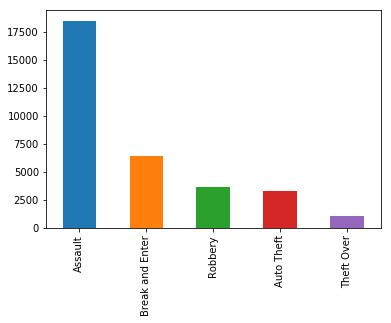

In [8]:
MCI_2016['MCI'].value_counts().plot(kind='bar')

print( MCI_2016['MCI'].value_counts().index.values[0] , " seems to be the highest occuring crime , with almost" , 
      int(round(MCI_2016['MCI'].value_counts()[0]/MCI_2016['MCI'].value_counts()[1])) ,"x the frequency of the next crime",
     MCI_2016['MCI'].value_counts().index.values[1])

*Apparently , assault =  initiate harmful or offensive contact with a person, or a threat to do so.*  
*break and enter = breaking into a commercial property or private residence in order to steal property*

**The summer months usually seem to have more crime  
This does not seem very unsual **

**The winter months seem to be lower on crime relatively with the exception of October **

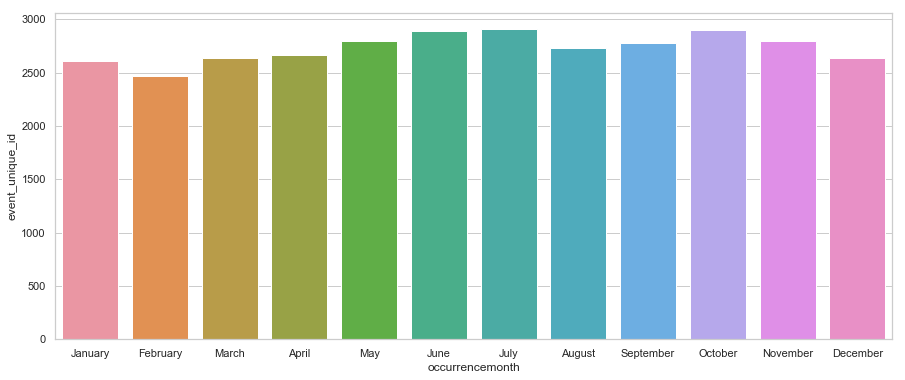

In [116]:
Occ_mo = MCI_2016.groupby('occurrencemonth')['event_unique_id'].count().reset_index().sort_values('event_unique_id')
sns.set(style="whitegrid")
ax = sns.barplot(x="occurrencemonth", y="event_unique_id", data=Occ_mo , 
                 order=['January', 'February','March','April','May','June','July','August','September',
                        'October','November','December'])

sns.set(rc={'figure.figsize':(15,6)})

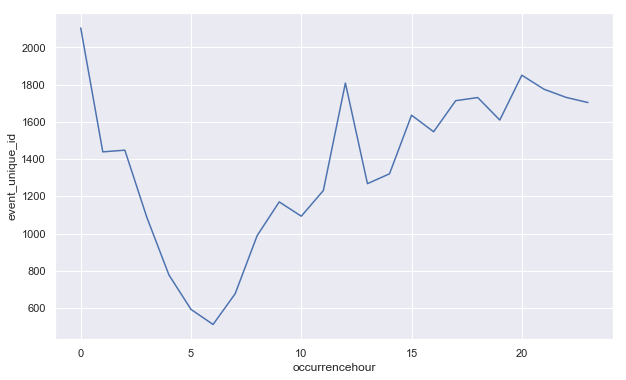

In [10]:
Occ_hr = MCI_2016.groupby(['occurrencehour'])['event_unique_id'].count().reset_index().sort_values('event_unique_id')
ax = sns.lineplot(x="occurrencehour", y="event_unique_id", data=Occ_hr)
sns.set(rc={'figure.figsize':(15,6)})

**Midnight , Mid Noon , Night 8 PM have the highest number of crimes comitted  
Usually the evenings and nights have a higher crime rate**

In [11]:
Occ_hr.sort_values(by = 'event_unique_id',ascending=False).head()

,occurrencehour,event_unique_id
0,0,2105
20,20,1851
12,12,1809
21,21,1776
22,22,1732


**Assault is highest at midnight , but is also higher in the evenings & nights  
Break & Enter has a different pattern , its relatively flat all through out the day but has a high during midnight(possibly as lesser number of people would be around )  
Auto Theft, Robbery are more frequent during evenings and nights  **

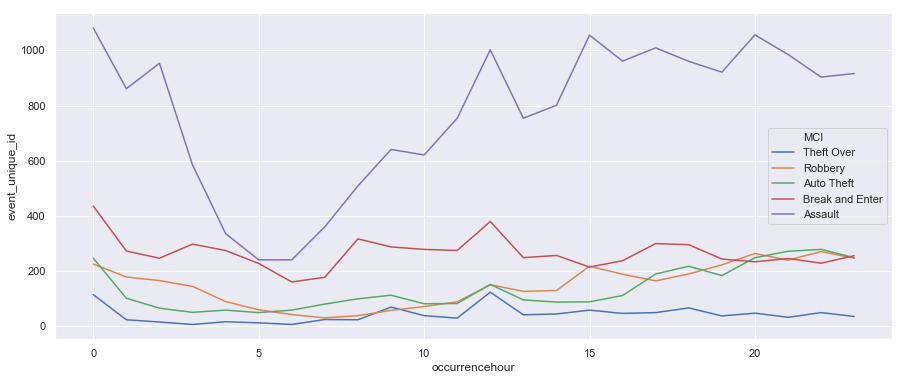

In [12]:
Occ_hr2 = MCI_2016.groupby(['occurrencehour','MCI'])['event_unique_id'].count().reset_index().sort_values('event_unique_id')
ax1 = sns.lineplot(x="occurrencehour", y="event_unique_id", hue="MCI",data=Occ_hr2)

**Waterfront Communities-The Island  has the highest number of assaults and also the highest number of break and enter crimes  
West Humber-Clairville has the highest number of auto thefts though  **

All in all , already with the exploratory analysis Church-Yonge Corridor, Waterfront Communities seems to be a risky place to stay  


MCI              Neighbourhood                         
Assault          Waterfront Communities-The Island (77)    793
                 Church-Yonge Corridor (75)                739
                 Bay Street Corridor (76)                  465
Auto Theft       West Humber-Clairville (1)                311
                 Islington-City Centre West (14)           130
                 York University Heights (27)              106
Break and Enter  Waterfront Communities-The Island (77)    194
                 Church-Yonge Corridor (75)                166
                 South Riverdale (70)                      143
Robbery          Church-Yonge Corridor (75)                173
                 Moss Park (73)                            118
                 Mount Olive-Silverstone-Jamestown (2)     115
Theft Over       Waterfront Communities-The Island (77)     56
                 Church-Yonge Corridor (75)                 43
                 West Humber-Clairville (1)                 40

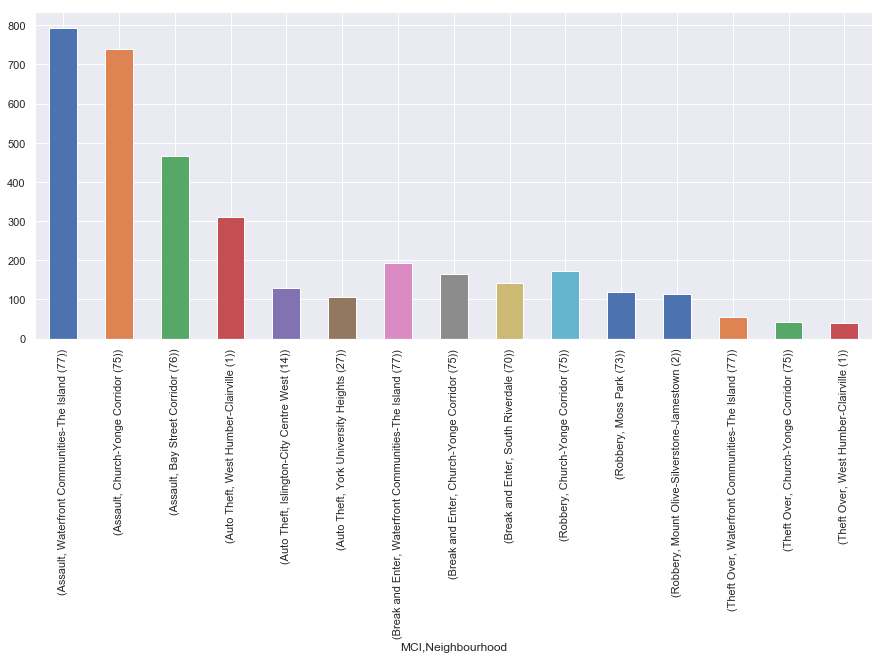

In [13]:
Occ_Nhood = MCI_2016.groupby(['MCI','Neighbourhood']).count()
MCI_Nhood = Occ_Nhood['event_unique_id'].groupby(level=0, group_keys=False)
MCI_Nhood.nlargest(3).plot(kind='bar')
MCI_Nhood.nlargest(3)

**Assault seems to occur equally frequently during any day , saturday seems be relatively higher   
Friday for Break and enter criminal and almost any day for an auto thief seem to be good days **

MCI              occurrencedayofweek
Assault          Saturday               3058
                 Sunday                 2994
                 Friday                 2733
                 Monday                 2547
                 Thursday               2464
Auto Theft       Friday                  514
                 Thursday                502
                 Saturday                498
                 Wednesday               450
                 Monday                  438
Break and Enter  Friday                 1052
                 Thursday                990
                 Tuesday                 937
                 Wednesday               913
                 Monday                  870
Robbery          Saturday                620
                 Friday                  529
                 Wednesday               521
                 Thursday                498
                 Sunday                  492
Theft Over       Friday                  183
                 M

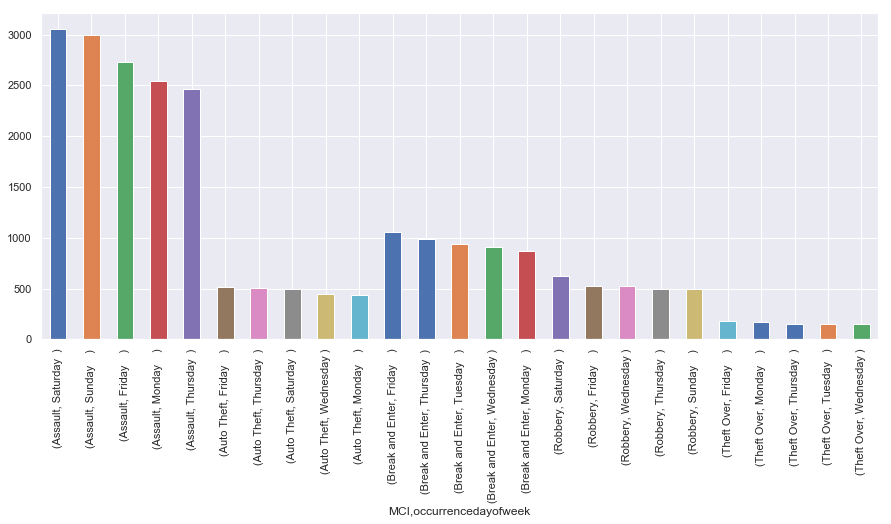

In [14]:
Occ_Nhood = MCI_2016.groupby(['MCI','occurrencedayofweek']).count()
MCI_Nhood = Occ_Nhood['event_unique_id'].groupby(level=0, group_keys=False)
MCI_Nhood.nlargest(5).plot(kind='bar')
MCI_Nhood.nlargest(5)

### Creating support functions to supplement the MCI data 

For each location where the crime occurred, lets get the data of the surrounding venues  
The location of the crime is mentioned in the form of latitude and logitude in the columns titled X & Y   
We will use these Geo Coordinates to send to foursquare and retrieve the venues located close to the crime scene  

Below , lets write a function to query foursquare and fetch the relevant data for each crime



In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    counter = 1 
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(counter)
        counter = counter+1
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        try:
            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']
        
            # Handle those post codes which have no results 
            if not results:
                print(name, " returned no results ",results )
            else:
                # return only relevant information for each nearby venue
                venues_list.append([(
                    name, 
                    lat, 
                    lng, 
                    v['venue']['name'], 
                    v['venue']['location']['lat'], 
                    v['venue']['location']['lng'],  
                    v['venue']['categories'][0]['name']) for v in results])
        except:
            print(requests.get(url).json())

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['event_unique_id', 
                  'MCI Latitude', 
                  'MCI Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now that we have a function to extract venues surrounding each crime scene  
Lets use that to extract the venue level data and save in a dataframe called Torrono_venues

In [16]:
#Takes over 2 hours to completely run as foursquare has to be queried over 32K times 

Torrono_venues = getNearbyVenues(names=MCI_2016['event_unique_id'],
                                    latitudes=MCI_2016['Y'],
                                    longitudes=MCI_2016['X'])

print(Torrono_venues.shape)
Torrono_venues.head()

(876412, 7)


,event_unique_id,MCI Latitude,MCI Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,GO-201633448,43.65432,-79.383202,Downtown Toronto,43.653232,-79.385296,Neighborhood
1,GO-201633448,43.65432,-79.383202,Indigo,43.653515,-79.380696,Bookstore
2,GO-201633448,43.65432,-79.383202,Japango,43.655268,-79.385165,Sushi Restaurant
3,GO-201633448,43.65432,-79.383202,Nathan Phillips Square,43.652270,-79.383516,Plaza
4,GO-201633448,43.65432,-79.383202,Crepe Delicious,43.654536,-79.380889,Fast Food Restaurant


### Cluster the MCI data with the venues data 

Each of the venue categories is dummy coded and converted to a column  
Next in preparation for the clustering , let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
 

In [17]:
# one hot encoding of the venue categories
Torrono_onehot = pd.get_dummies(Torrono_venues[['Venue Category']], prefix="", prefix_sep="")

# add postcode column back to dataframe
Torrono_onehot['event_unique_id'] = Torrono_venues['event_unique_id'] 

# move neighborhood column to the first column
fixed_columns = [Torrono_onehot.columns[-1]] + list(Torrono_onehot.columns[:-1])
Torrono_onehot = Torrono_onehot[fixed_columns]

Torrono_grouped = Torrono_onehot.groupby('event_unique_id').mean().reset_index()
Torrono_grouped.head(2)

,event_unique_id,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,...,Volleyball Court,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
0,GO-20161000017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.034483,0.0,0.0,0.0,0.0
1,GO-20161000038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


Now we have a data frame which has  
- Rows as a crime 
- Columns as venues 
- values as the average frequency with which the venue is to the crime 

Lets use a 5 cluster KNN algorithm to cluster these into logical groups 

In [18]:
# set number of clusters
kclusters = 5

Torrono_grouped_clustering = Torrono_grouped.drop('event_unique_id', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=4 ).fit(Torrono_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print(len(kmeans.labels_))
kmeans.labels_

28122


array([0, 3, 0, ..., 0, 0, 0])

Make a dataframe of the top 10 venues near each MCI event unique id   
This will help us build a better view of the cluster when the outputs are there  


In [19]:
#function to sort venues in descending order of frequency
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# Storing the number of venues for each MCI event we want to consider
num_top_venues = 10


#just to ensure the column headers are readable 
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['event_unique_id']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['event_unique_id'] = Torrono_grouped['event_unique_id']

for ind in np.arange(Torrono_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Torrono_grouped.iloc[ind, :], num_top_venues)

print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head()

(28122, 11)


,event_unique_id,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,GO-20161000017,Chinese Restaurant,Bakery,Ice Cream Shop,Bank,Dim Sum Restaurant,Liquor Store,Beer Store,Sandwich Place,Clothing Store,Coffee Shop
1,GO-20161000038,IT Services,Grocery Store,Asian Restaurant,Sushi Restaurant,Festival,Empanada Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit
2,GO-20161000083,Coffee Shop,Restaurant,Café,Pizza Place,Bakery,Beer Store,Gastropub,Diner,Japanese Restaurant,Italian Restaurant
3,GO-2016100015,Burger Joint,Burrito Place,Supermarket,Furniture / Home Store,Clothing Store,Gym / Fitness Center,Greek Restaurant,Laser Tag,Sandwich Place,Chinese Restaurant
4,GO-20161000417,Coffee Shop,Sandwich Place,Café,Chinese Restaurant,Vietnamese Restaurant,Arts & Crafts Store,Bar,Dumpling Restaurant,Breakfast Spot,Restaurant


In [20]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Torrono_merged = MCI_2016
#Torrono_merged.rename(columns = {'event_unique_id':'Postcode'}, inplace = True)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Torrono_merged = Torrono_merged.join(neighborhoods_venues_sorted.set_index('event_unique_id'), on='event_unique_id')

Torrono_merged.dropna(subset=['Cluster Labels'], axis =0, inplace = True)

print(Torrono_merged.shape)
Torrono_merged.head()

(32596, 30)


,X,Y,event_unique_id,premisetype,offence,reportedyear,reportedmonth,reportedday,reporteddayofyear,reporteddayofweek,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5055,-79.383202,43.654320,GO-201633448,Outside,Robbery - Swarming,2016,January,6,6,Wednesday,...,Coffee Shop,Clothing Store,Fast Food Restaurant,Sushi Restaurant,Tea Room,Cosmetics Shop,Restaurant,Seafood Restaurant,Bubble Tea Shop,Asian Restaurant
5288,-79.544701,43.632122,GO-201630054,Commercial,B&E,2016,January,6,6,Wednesday,...,Fast Food Restaurant,Vietnamese Restaurant,Restaurant,Concert Hall,Baseball Field,Pizza Place,Zoo Exhibit,Farm,Falafel Restaurant,Fabric Shop
5329,-79.433281,43.637745,GO-201629453,Apartment,Assault With Weapon,2016,January,6,6,Wednesday,...,Café,Pizza Place,Indian Restaurant,Diner,Tibetan Restaurant,Light Rail Station,Bakery,Bank,Restaurant,Coffee Shop
5330,-79.374352,43.662918,GO-201629375,Apartment,B&E,2016,January,6,6,Wednesday,...,Japanese Restaurant,Coffee Shop,Diner,Fast Food Restaurant,Ramen Restaurant,Gastropub,Grocery Store,Sandwich Place,Clothing Store,Theater
5331,-79.403870,43.666660,GO-201634311,Outside,Robbery - Mugging,2016,January,6,6,Wednesday,...,Café,Restaurant,Bakery,Bookstore,Bar,Japanese Restaurant,Italian Restaurant,Pub,Sandwich Place,Gym


### Interpreting the results
Lets try plotting the cluster results so we understand some of the cluster details better  
Since we have multiple variables but can only visualize 2D or 3D charts  
we are doing a PCA to reduce the number of variables to 3, so we can try fittingin a 3D chart  


In [21]:
from sklearn.decomposition import PCA 
  
pca = PCA(3) 
pca.fit(Torrono_grouped_clustering) 
  
pca_data = pd.DataFrame(pca.transform(Torrono_grouped_clustering)) 
  
print(pca_data.head())

          0         1         2
0 -0.012284 -0.041467 -0.002898
1 -0.035418 -0.101780  0.071003
2 -0.037285  0.005637 -0.024895
3 -0.043097 -0.044821 -0.022855
4 -0.058599  0.115402 -0.036122


Below are the cluster plots using the PCA results   
They plotted with and without the labels so clusters can be seen more clearly    

- **Cluster 4 seems to be evidently different from the rest of the clusters , towards the right bottom of the chart **   
-- It also has some outliers  
-- Rest of the clusters seem to be closely knit  
- **Clusters 1 & 2 are close and beside cluster 4 **
- **Clusters 0 & 3 are distinct towards the left of the chart , with cluster 0 below cluster 3 **

Cluster Plot with labels


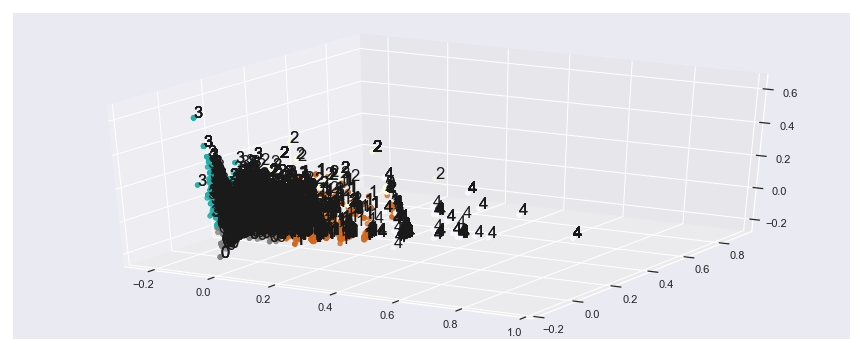

Cluster Plot without labels


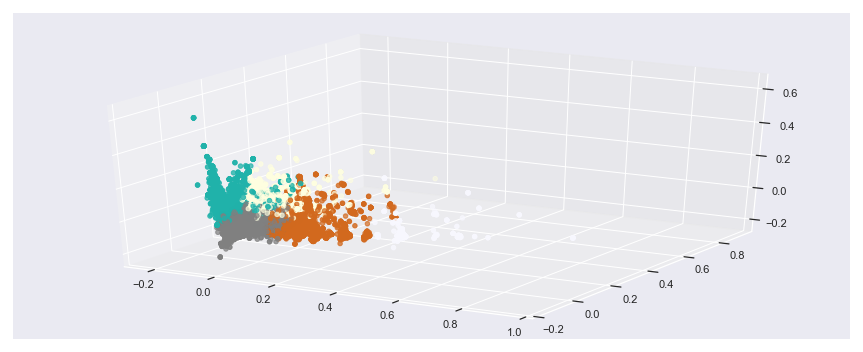

In [22]:
cluster_colors = ('grey', 'chocolate', 'lightyellow', 'lightseagreen', 'ghostwhite', 'hotpink')
fig = plt.figure() 

# This plots the cluster with labels    
ax = fig.add_subplot(111, projection = '3d') 
ax.scatter(pca_data[0], pca_data[1], pca_data[2],  
           c = list(map(lambda label : cluster_colors[label], 
                                            kmeans.labels_))) 
   
str_labels = list(map(lambda label:'% s' % label, kmeans.labels_)) 

print("Cluster Plot with labels")

list(map(lambda data1, data2, data3, str_label: 
        ax.text(data1, data2, data3, s = str_label, size = 16.5, 
        zorder = 20, color = 'k'), pca_data[0], pca_data[1], 
        pca_data[2], str_labels)) 

plt.show()



fig1 = plt.figure() 
ax1 = fig1.add_subplot(111, projection = '3d') 
ax1.scatter(pca_data[0], pca_data[1], pca_data[2],  
           c = list(map(lambda label : cluster_colors[label], 
                                            kmeans.labels_))) 
   
str_labels = list(map(lambda label:'% s' % label, kmeans.labels_)) 

# This plots the cluster without labels    
print("Cluster Plot without labels")

list(map(lambda data1, data2, data3: 
        ax.text(data1, data2, data3, s = '', size = 16.5, 
        zorder = 20, color = 'k'), pca_data[0], pca_data[1], 
        pca_data[2])) 
   
plt.show()

In [31]:
Torrono_merged.columns

Index(['X', 'Y', 'event_unique_id', 'premisetype', 'offence', 'reportedyear',
       'reportedmonth', 'reportedday', 'reporteddayofyear',
       'reporteddayofweek', 'reportedhour', 'occurrenceyear',
       'occurrencemonth', 'occurrenceday', 'occurrencedayofyear',
       'occurrencedayofweek', 'occurrencehour', 'MCI', 'Neighbourhood',
       'Cluster Labels', '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue'],
      dtype='object')

Creating a pivot table between Clusters and crimes to see tha split  
The values are calculated as %ages to allow for easy comparison across the clusters & crimes   


In [118]:
cl_mci_tab1 = pd.pivot_table(Torrono_merged, values='event_unique_id',  index=['Cluster Labels'], 
                             columns=['MCI'],aggfunc=[len], margins = True)
cl_mci_tab2 = cl_mci_tab1.div(cl_mci_tab1.iloc[:,-1]/100, axis=0 ).round(2)
cl_mci_tab2
#.reset_index()

len                                                     
MCI            Assault Auto Theft Break and Enter Robbery Theft Over    All
Cluster Labels                                                             
0.0              56.54       9.27           20.36   10.32       3.51  100.0
1.0              55.39      10.76           20.93   10.21       2.71  100.0
2.0              56.96      10.26           17.53   11.90       3.35  100.0
3.0              58.02      10.57           15.93   13.33       2.14  100.0
4.0              45.86      14.45           27.99    9.20       2.50  100.0
All              56.50       9.89           19.46   11.02       3.13  100.0

Heatmap of the same in absolute numbers to see the magnitude of difference  

-Cluster 0 has all crimes the highest in absolute values   
-Break enter is relatively higher in Cluster 4  
-Similarly for cluster 3 , Robbery & auto theft are relatively higher  
-Cluster 1 & 2 seem to be close to cluster 4 as seen also in the 3D cluster charts above  


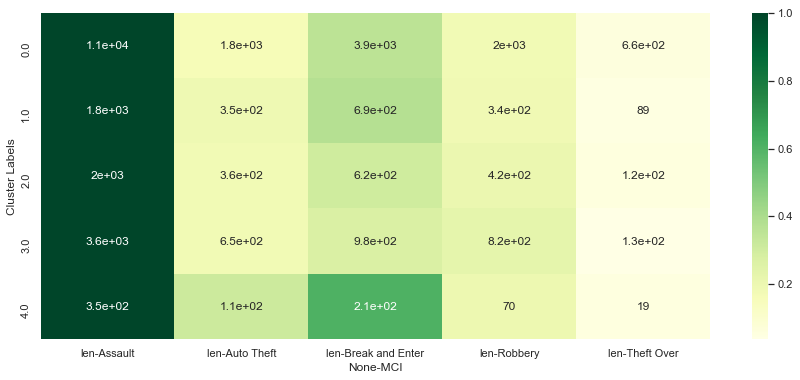

In [126]:
cl_mci_hmap = pd.pivot_table(Torrono_merged, values='event_unique_id', index=['Cluster Labels'], columns=['MCI'],aggfunc=[len])
cl_mci_hmap_norm = cl_mci_hmap.div(cl_mci_hmap.max(axis=1), axis=0)
ax3 = sns.heatmap(cl_mci_hmap_norm, annot  = cl_mci_hmap, cmap = 'YlGn')

#### Cluster 4 primarily has Break and Enter crimes in a relatively higher proportion , and most of these crimes happen to have the first most common venue to be a park , especially around the Willowdale West neighbourhood
Cluster 4 also has Auto theft in a high proportion


In [102]:
C4 = Torrono_merged[Torrono_merged['Cluster Labels']== 4].copy()
print('The % of parks in cluster 4 ', round(len(C4[C4['1st Most Common Venue'] == 'Park'])*100/len(C4)))
print('The % of break & enter crimes near parks in cluster 4 is ',
      round(len(C4[   (C4['MCI'] == 'Break and Enter') & (C4['1st Most Common Venue'] == 'Park') ])*100 
            /len(C4[C4['MCI'] == 'Break and Enter'])))



The % of parks in cluster 4  82
The % of break & enter crimes near parks in cluster 4 is  87


A map of only cluster 4 is plotted to see the dispersion across neighbourhoods  
The noeth western neighbourhoods seem to have higher proportion of crimes in cluster 4  

In [60]:
C4_map = folium.Map(location=[43.6932, -79.3832], zoom_start=11)

FastMarkerCluster(data=list(zip(C4['Y'], C4['X']))).add_to(C4_map)
folium.LayerControl().add_to(C4_map)


C4_map

A detailed map of cluster 4 crimes is plotted below  
each crime is indicated by a cirle and the first neighbour hood close to the area of the crime is listed in the hover  
It can be noticed that for most of the circles/crimes in the north western part of the city , there is a park close by 

In [96]:
C4_nb = C4[(C4['MCI'] == 'Break and Enter') & (C4['1st Most Common Venue'] == 'Park')]
print("Top 2 neighbourhoods which have a park close by the Break and enter crime scene")
print(C4_nb.groupby('Neighbourhood').count()['event_unique_id'].sort_values( ascending = False).head(2))


# create map
map_clusters = folium.Map(location=[43.6932, -79.3832], zoom_start=11)

#Neighbourhood
# add markers to the map
markers_colors = []
for lat, lon, poi in zip(C4['Y'], C4['X'], C4['1st Most Common Venue'] ):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='#8000ff',
        fill=True,
        fill_color='#8000ff',
        fill_opacity=0.4).add_to(map_clusters)
       
map_clusters

Top 2 neighbourhoods which have a park close by the Break and enter crime scene
Neighbourhood
Willowdale West (37)        11
Stonegate-Queensway (16)    10
Name: event_unique_id, dtype: int64


#### Cluster 3 seems to have a higher proportion of Robbery and has Fast Food Restaurants close by to the crime scene
Cluster 3 also has a higher proportion of Assault which also happens close to Fast Food restaurants

In [98]:
C3 = Torrono_merged[Torrono_merged['Cluster Labels']== 3].copy()
print("Crime that has a relative higher proprtion in cluster 3 is Robbery @ " , 
      round(len(C3[C3['MCI'] == 'Robbery'])*100/len(C3)))
print(" ")
print("Top venues close to a robbery crime scene in cluster 3 are ")
C3[C3['MCI'] == 'Robbery'].groupby('1st Most Common Venue').count()['event_unique_id'].sort_values( ascending = False).head(2)

Crime that has a relative higher proprtion in cluster 3 is Robbery @  13
 
Top venues close to a robbery crime scene in cluster 3 are 


1st Most Common Venue
Fast Food Restaurant    157
Grocery Store           143
Name: event_unique_id, dtype: int64

Cluster 3 is concentrated in the North Western Toronto , followed by eastern Toronto  
Black Creek , West hill neighbourhoods primarily which are on either side of the town   


In [158]:
C3_map = folium.Map(location=[43.6932, -79.3832], zoom_start=11)
FastMarkerCluster(data=list(zip(C3['Y'], C3['X']))).add_to(C3_map)
folium.LayerControl().add_to(C3_map)
C3_map

#### Cluster 0 has the highest absolute number of Assualt cases registered. 40% of these seem to happen close to a coffee shop

In [105]:
C0 = Torrono_merged[Torrono_merged['Cluster Labels']== 0].copy()
print("The number of assault cases in cluster 0 are " , len(C0[C0['MCI'] == 'Assault']))
print("These form ", round(len(C0[C0['MCI'] == 'Assault']) * 100/ len(Torrono_merged[Torrono_merged['MCI'] == 'Assault']) )  
      , "percentage of the total assault crimes registered in Toronto in 2016")
print(" ")
print("The most common venues around this cluster and MCI being assault are coffee shops ")
C0[C0['MCI'] == 'Assault'].groupby('1st Most Common Venue').count()['event_unique_id'].sort_values( ascending = False).head(2)


The number of assault cases in cluster 0 are  10693
These form  58 percentage of the total assault crimes registered in Toronto in 2016
 
The most common venues around this cluster and MCI being assault are coffee shops 


1st Most Common Venue
Coffee Shop    3413
Café            932
Name: event_unique_id, dtype: int64

In [113]:
print("Top venues close to a Assault crime scene in cluster 0 are ")
print(C0_nb.groupby('Neighbourhood').count()['event_unique_id'].sort_values( ascending = False).head(4))


C0_map = folium.Map(location=[43.6932, -79.3832], zoom_start=11)

C0_nb =C0[
    (C0['MCI'] == 'Assault') & 
    ((C0['1st Most Common Venue'] == 'Coffee Shop') | (C0['1st Most Common Venue'] == 'Café')) 
]

FastMarkerCluster(data=list(zip(C0_nb['Y'], C0_nb['X']))).add_to(C0_map)
folium.LayerControl().add_to(C0_map)


C0_map

Top venues close to a Assault crime scene in cluster 0 are 
Neighbourhood
Church-Yonge Corridor (75)                717
Waterfront Communities-The Island (77)    669
Bay Street Corridor (76)                  362
Moss Park (73)                            310
Name: event_unique_id, dtype: int64


**Cluster 1 has a higher proportion of Assault, Break and Enter with the risk majorly around homes near parks**

In [188]:
C1 = Torrono_merged[Torrono_merged['Cluster Labels']== 1].copy()

print("Crime that has a relative higher proprtion in cluster 1 is Assault @ " , 
      round(len(C1[C1['MCI'] == 'Assault'])*100/len(C1)))
print(" ")
print("Top venue close to a crime scene in cluster 1 is a",
      C1.groupby('1st Most Common Venue').count()['event_unique_id'].sort_values( ascending = False).head(1).reset_index().iloc[0,0])

print(" ")

print("The target premise in this cluster for the crime is likely to be a ",
      C1.groupby('premisetype').count()['event_unique_id'].sort_values( ascending = False).head(1).reset_index().iloc[0,0])



Crime that has a relative higher proprtion in cluster 1 is Assault @  55
 
Top venue close to a crime scene in cluster 1 is a Park
 
The target premise in this cluster for the crime is likely to be a  House


In [159]:
C1_map = folium.Map(location=[43.6932, -79.3832], zoom_start=11)

FastMarkerCluster(data=list(zip(C1['Y'], C1['X']))).add_to(C1_map)
folium.LayerControl().add_to(C1_map)

C1_map

**Cluster 2 is Comparable to cluster 1 in some ways with difference in the targets of crime.  
Cluster 2 is focussed on Apartments and Commercial spaces with Coffee shops in the neighbourhood **

In [218]:
C2 = Torrono_merged[Torrono_merged['Cluster Labels']== 2].copy()

print("Crime that has a relative higher proprtion in cluster 2 is Break & enter @ " , 
      round(len(C2[C2['MCI'] == 'Break and Enter'])*100/len(C2)), "%")
print(" ")
print("Top venue close to a crime scene in cluster 2 is a",
      C2.groupby('1st Most Common Venue').count()['event_unique_id'].sort_values( ascending = False).head(1).reset_index().iloc[0,0])

print(" ")


print("Cluster 1 & 2 are comparable in number of crimes(~3k each) but a clear distinction in the premises can be observed")
print("--Cluster 1 predominantly is focussed around homes with 1152 of the 3282 crimes occuring there")
print("--Cluster 2 crimes are predominantly  focussed around commercial (582) , appartments(993) & outside(950) instead of homes")

pd.pivot_table(Torrono_merged, values='event_unique_id',  index=['Cluster Labels'], 
                             columns=['premisetype'],aggfunc=[len], margins = True)



Crime that has a relative higher proprtion in cluster 2 is Break & enter @  18 %
 
Top venue close to a crime scene in cluster 2 is a Coffee Shop
 
Cluster 1 & 2 are comparable in number of crimes(~3k each) but a clear distinction in the premises can be observed
--Cluster 1 predominantly is focussed around homes with 1152 of the 3282 crimes occuring there
--Cluster 2 crimes are predominantly  focussed around commercial (582) , appartments(993) & outside(950) instead of homes


len                                      
premisetype    Apartment Commercial House Other Outside    All
Cluster Labels                                                
0.0                 4208       4303  2770  2170    5462  18913
1.0                  857        199  1152   355     719   3282
2.0                  993        582   521   474     950   3520
3.0                 1749       1055  1117   558    1641   6120
4.0                  139         32   370    71     149    761
All                 7946       6171  5930  3628    8921  32596

Cluster 2 is also a split cluster , focussed on Western(527) & Eastern parts(590) of Toronto City   
West Humber-Clairville , Scarborough Village being the top 2 neighbourhoods  


In [160]:
C2_map = folium.Map(location=[43.6932, -79.3832], zoom_start=11)

FastMarkerCluster(data=list(zip(C2['Y'], C2['X']))).add_to(C2_map)
folium.LayerControl().add_to(C2_map)

C2_map

#### Summarized takeaways 

- Cluster 0 – Centred around down town, Almost all MCI Crime types are higher in absolute numbers. Crime scenes largely are around Coffee shops and Cafes  
- Cluster 1 – Assault, Break and Enter are relatively higher with the risk majorly around homes near parks  
- Cluster 2 – Comparable to cluster 1 in some ways with difference in the targets of crime. Focusses on Apartments and Commercial spaces with Coffee shops in the neighbourhood  
- Cluster 3 –Robbery and Auto Theft around Fast Food joints and Pizza places seem to be relatively higher   
- Cluster 4 – Largely Break and enter crimes on homes in the western suburbs of Toronto. Parks seem to be closest to these crime scene  


In [221]:
print("Fin")

Fin
